# Step1
import thư viện

In [12]:

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import string
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV

# Step2
Tải dữ liệu

In [13]:
payloads = pd.read_csv("dataset/payloads.csv",index_col='index')
display(payloads.head(20))

,payload,is_malicious,injection_type
index,,,
0,Ellyn,0,LEGAL
1,' and '2'='2,1,SQL
2,8527,0,LEGAL
3,22205546N,0,LEGAL
4,Dayton,0,LEGAL
5,invaders,0,LEGAL
6,Do9TRInaDor,0,LEGAL
7,usuarios,0,LEGAL
8,.test,0,LEGAL


# Step3A - Tạo custom features  
Tạo những đặc trưng cho bài toán, bao gồm:
 - Độ dài dữ liệu
 - Số lượng dấu câu trong dữ liệu
 - Byte nhỏ nhất trong dữ liệu
 - Trung bình byte trong dữ liệu
 - Độ lệch chuẩn byte trong dữ liệu
 - Số lượng từ khóa SQL trong dữ liệu
 - Số lượng từ khóa JS trong dữ liệu

In [14]:
# Tạo biểu đồ phân phối của các đặc trưng
def plot_feature_distribution(features):
    print('Properties of feature: ' + features.name)
    print(features.describe())
    f, a = plt.subplots(1, figsize=(10, 6))
    a.hist(features, bins=features.max()-features.min()+1)
    a.set_xlabel('value')
    a.set_ylabel('fraction')
    plt.show()

Tạo đặc trưng Độ dài dữ liệu

,payload,is_malicious,injection_type,length
index,,,,
0,Ellyn,0,LEGAL,5
1,' and '2'='2,1,SQL,12
2,8527,0,LEGAL,4
3,22205546N,0,LEGAL,9
4,Dayton,0,LEGAL,6


Properties of feature: length
count    109493.000000
mean         16.199693
std          31.662881
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max        2074.000000
Name: length, dtype: float64


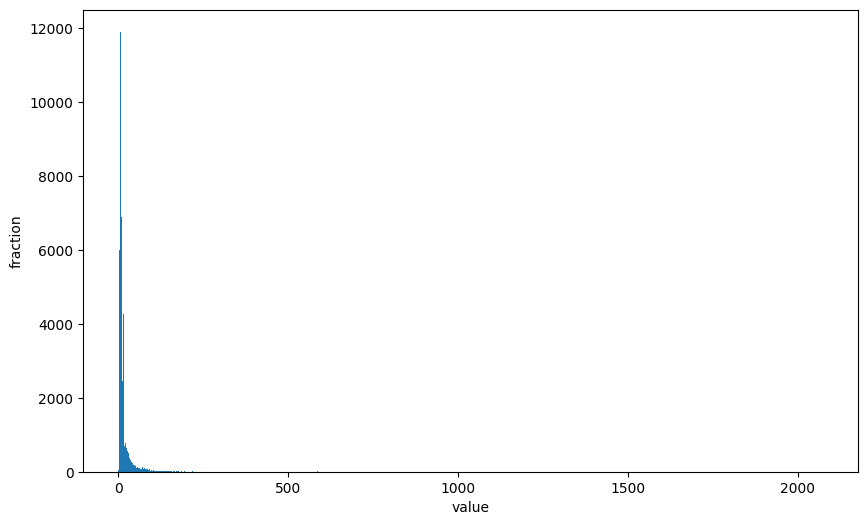

In [15]:
def create_feature_length(payloads):

    payloads['length'] = [len(str(s)) for s in payloads['payload']]
    return payloads

payloads = create_feature_length(payloads)
display(payloads.head())

plot_feature_distribution(payloads['length'])


Tạo đặc trưng Số dấu câu trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation
index,,,,,
0,Ellyn,0,LEGAL,5,0
1,' and '2'='2,1,SQL,12,5
2,8527,0,LEGAL,4,0
3,22205546N,0,LEGAL,9,0
4,Dayton,0,LEGAL,6,0


Properties of feature: punctuation
count    109493.000000
mean          2.258427
std           9.545707
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         538.000000
Name: punctuation, dtype: float64


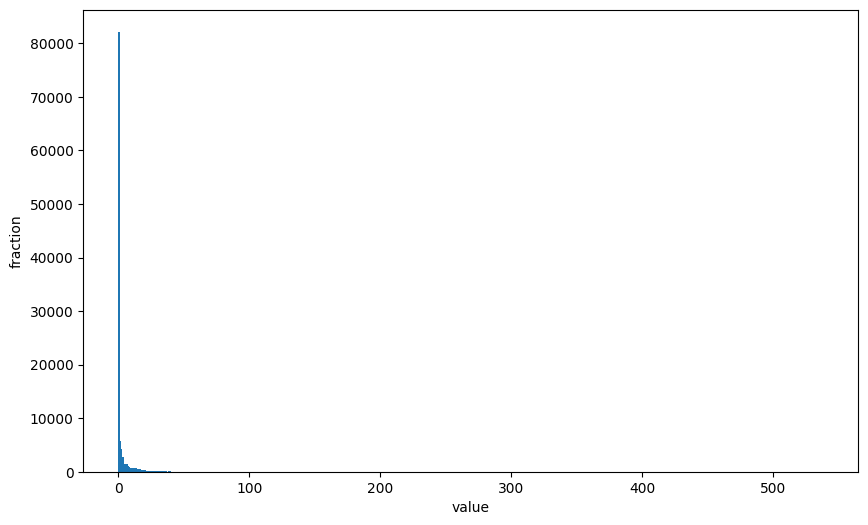

In [16]:
def create_feature_punctuation_characters(payloads):

    payloads['punctuation'] = [ len([1 for letter in str(s) if letter in string.punctuation]) for s in payloads['payload']]
    return payloads
    
create_feature_punctuation_characters(payloads)
display(payloads.head())
    
plot_feature_distribution(payloads['punctuation'])

Tạo đặc trưng Byte nhỏ nhất trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte
index,,,,,,
0,Ellyn,0,LEGAL,5,0,69
1,' and '2'='2,1,SQL,12,5,32
2,8527,0,LEGAL,4,0,50
3,22205546N,0,LEGAL,9,0,48
4,Dayton,0,LEGAL,6,0,68


Properties of feature: min-byte
count    109493.000000
mean         71.489648
std          26.452552
min           9.000000
25%          48.000000
50%          76.000000
75%          97.000000
max         125.000000
Name: min-byte, dtype: float64


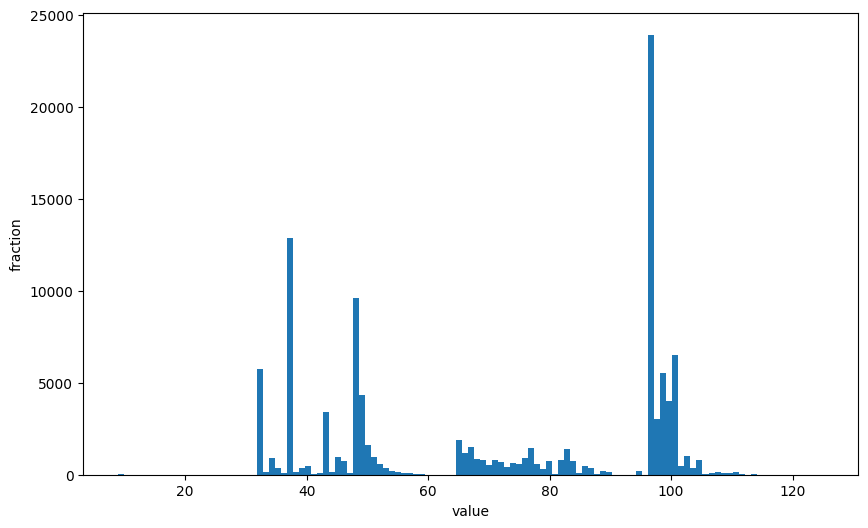

In [17]:
def create_feature_min_byte_value(payloads):
    
    payloads['min-byte'] = [ min(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_min_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['min-byte'])

Tạo đặc trưng Trung bình byte trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte,mean-byte
index,,,,,,,
0,Ellyn,0,LEGAL,5,0,69,103.200000
1,' and '2'='2,1,SQL,12,5,32,57.333333
2,8527,0,LEGAL,4,0,50,53.500000
3,22205546N,0,LEGAL,9,0,48,54.222222
4,Dayton,0,LEGAL,6,0,68,103.833333


Properties of feature: mean-byte
count    109493.000000
mean         92.622314
std          19.319479
min          32.000000
25%          83.000000
50%         102.000000
75%         107.000000
max         164.000000
Name: mean-byte, dtype: float64


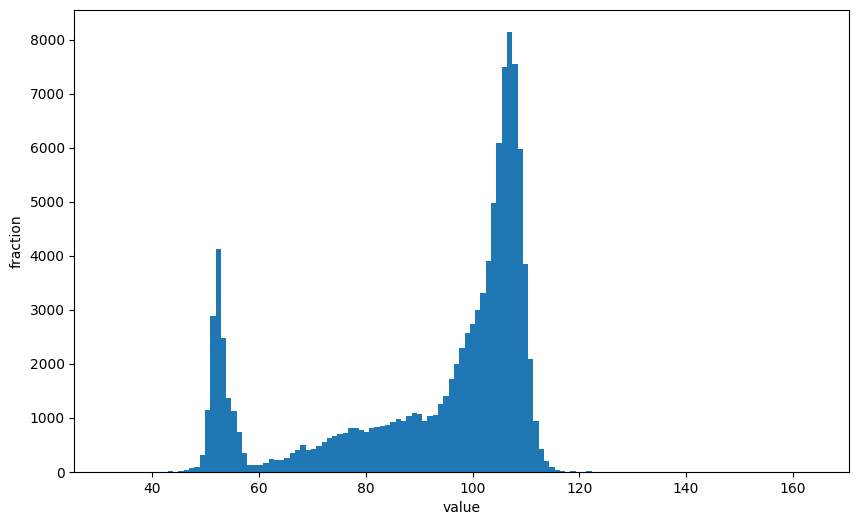

In [18]:
def create_feature_mean_byte_value(payloads):
    '''
    Feature
    Maximum byte value in payload
    '''
    
    payloads['mean-byte'] = [ np.mean(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_mean_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['mean-byte'].astype(int))

Tạo đặc trưng Độ lệch chuẩn byte trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte,mean-byte,std-byte
index,,,,,,,,
0,Ellyn,0,LEGAL,5,0,69,103.200000,17.769637
1,' and '2'='2,1,SQL,12,5,32,57.333333,27.259045
2,8527,0,LEGAL,4,0,50,53.500000,2.291288
3,22205546N,0,LEGAL,9,0,48,54.222222,8.599454
4,Dayton,0,LEGAL,6,0,68,103.833333,17.620222


Properties of feature: std-byte
count    109493.000000
mean         12.051081
std           9.140370
min           0.000000
25%           5.000000
50%           7.000000
75%          20.000000
max          75.000000
Name: std-byte, dtype: float64


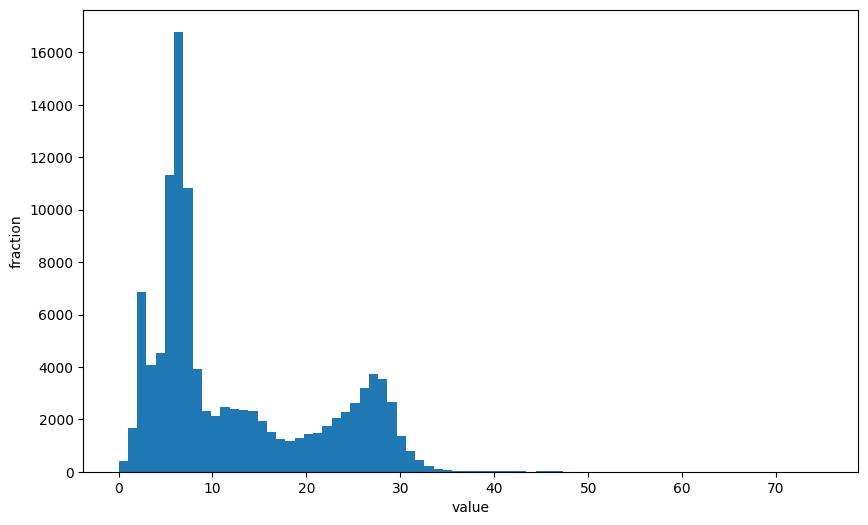

In [19]:
def create_feature_std_byte_value(payloads):

    payloads['std-byte'] = [ np.std(bytearray(str(row), 'utf8')) for row in payloads['payload']]
    return payloads

create_feature_std_byte_value(payloads)
display(payloads.head())

plot_feature_distribution(payloads['std-byte'].astype(int))

Tạo đặc trưng Số từ khóa SQL trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte,mean-byte,std-byte,sql-keywords
index,,,,,,,,,
0,Ellyn,0,LEGAL,5,0,69,103.200000,17.769637,0
1,' and '2'='2,1,SQL,12,5,32,57.333333,27.259045,1
2,8527,0,LEGAL,4,0,50,53.500000,2.291288,0
3,22205546N,0,LEGAL,9,0,48,54.222222,8.599454,0
4,Dayton,0,LEGAL,6,0,68,103.833333,17.620222,0


Properties of feature: sql-keywords
count    109493.000000
mean          0.186450
std           0.628935
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: sql-keywords, dtype: float64


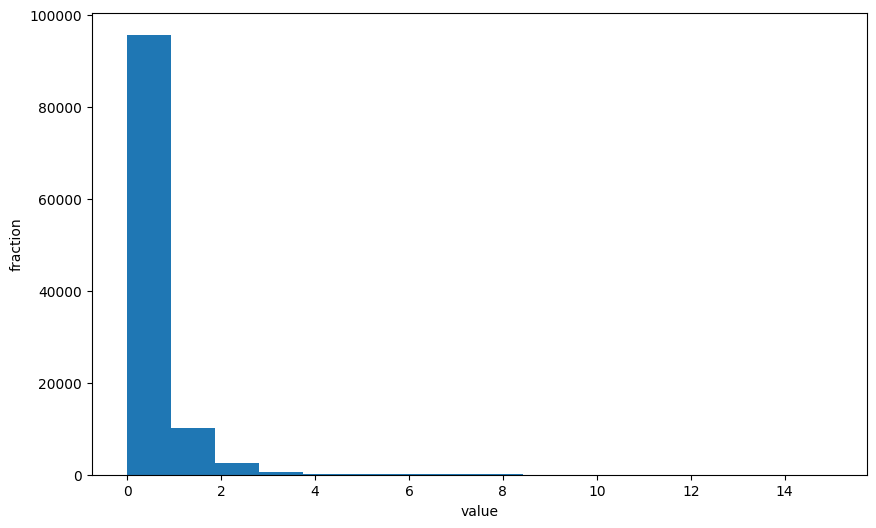

In [20]:
sql_keywords = pd.read_csv('dataset/SQLKeywords.txt', index_col=False)

def create_feature_sql_keywords(payloads):

    payloads['sql-keywords'] = [ len([1 for keyword in sql_keywords['Keyword'] if str(keyword).lower() in str(s).lower()]) for s in payloads['payload']]
    return payloads

create_feature_sql_keywords(payloads)
display(payloads.head())
plot_feature_distribution(payloads['sql-keywords'])
    

Tạo đặc trưng số từ khóa JS trong dữ liệu

,payload,is_malicious,injection_type,length,punctuation,min-byte,mean-byte,std-byte,sql-keywords,js-keywords
index,,,,,,,,,,
0,Ellyn,0,LEGAL,5,0,69,103.200000,17.769637,0,0
1,' and '2'='2,1,SQL,12,5,32,57.333333,27.259045,1,0
2,8527,0,LEGAL,4,0,50,53.500000,2.291288,0,0
3,22205546N,0,LEGAL,9,0,48,54.222222,8.599454,0,0
4,Dayton,0,LEGAL,6,0,68,103.833333,17.620222,0,0


Properties of feature: js-keywords
count    109493.000000
mean          0.346387
std           0.798850
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: js-keywords, dtype: float64


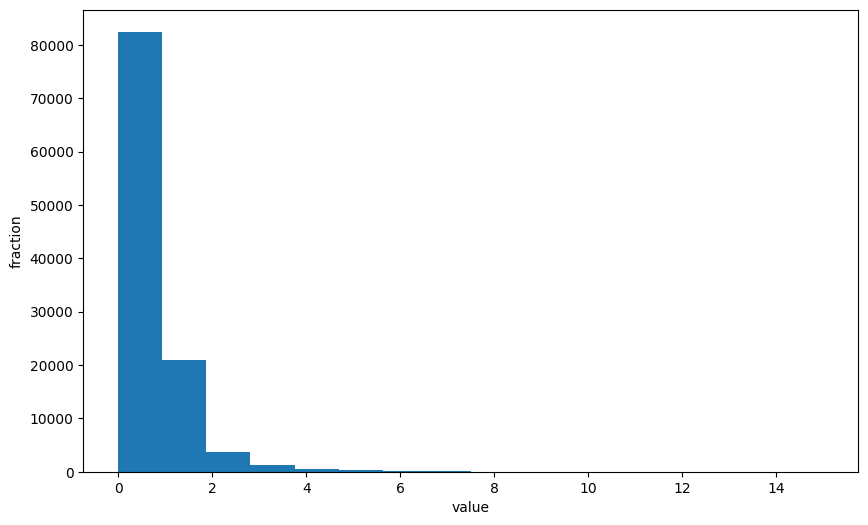

In [21]:
js_keywords = pd.read_csv('dataset/JavascriptKeywords.txt', index_col=False)

def create_feature_javascript_keywords(payloads):
    
    payloads['js-keywords'] = [len([1 for keyword in js_keywords['Keyword'] if str(keyword).lower() in str(s).lower()]) for s in payloads['payload']]
    return payloads
    

create_feature_javascript_keywords(payloads)
display(payloads.head())    
plot_feature_distribution(payloads['js-keywords'])
    
classifier = pickle.load( open("data/tfidf_2grams_randomforest.p", "rb"))    

Sử dụng custom features tạo vector đặc trưng từ dữ liệu 

In [22]:
def create_features(payloads):
    features = create_feature_length(payloads)
    features = create_feature_punctuation_characters(features)
    features = create_feature_min_byte_value(features)
    features = create_feature_mean_byte_value(features)
    features = create_feature_std_byte_value(features)
    features = create_feature_sql_keywords(features)
    features = create_feature_javascript_keywords(features)
    del features['payload']
    return features

create_features(pd.DataFrame(payloads['payload'].copy()))

,length,punctuation,min-byte,mean-byte,std-byte,sql-keywords,js-keywords
index,,,,,,,
0,5,0,69,103.200000,17.769637,0,0
1,12,5,32,57.333333,27.259045,1,0
2,4,0,50,53.500000,2.291288,0,0
3,9,0,48,54.222222,8.599454,0,0
4,6,0,68,103.833333,17.620222,0,0
...,...,...,...,...,...,...,...
109548,6,0,97,105.500000,6.776184,0,0
109549,13,0,48,51.769231,2.043897,0,0
109550,9,0,97,105.888889,6.488356,0,0


# Step3B - Tạo đặc trưng sử dụng kĩ thuật bag-of-words
Ngoài custom feature, ta tạo thêm 4 đặc trưng sử dụng kĩ thuật bag-of-words.
Ta sẽ thực hiện kiểm tra hiệu suất độc lập với custom features tại Step 3A.  
Những đặc trưng bao gồm:
- 1-grams CountVectorizer
- 2-grams CountVectorizer
- 1-grams TfidfVectorizer
- 2-grams TfidfVectorizer


### 1-Grams features
Tạo Countvectorizer và TF-IDFvectorizer sử dụng 1-grams.  

In [23]:
def get1Grams(payload_obj):
    '''
    Ví dụ: input - payload: "<script>"
             output- ["<","s","c","r","i","p","t",">"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-1):
        ngrams.append(payload[i:i+1])
    return ngrams

tfidf_vectorizer_1grams = TfidfVectorizer(tokenizer=get1Grams, token_pattern=None)
count_vectorizer_1grams = CountVectorizer(min_df=1, tokenizer=get1Grams, token_pattern=None)

### 2-Grams features
Tạo Countvectorizer và TF-IDFvectorizer sử dụng 2-grams.

In [24]:
def get2Grams(payload_obj):
    '''
    Ví dụ: input - payload: "<script>"
             output- ["<s","sc","cr","ri","ip","pt","t>"]
    '''
    payload = str(payload_obj)
    ngrams = []
    for i in range(0,len(payload)-2):
        ngrams.append(payload[i:i+2])
    return ngrams

tfidf_vectorizer_2grams = TfidfVectorizer(tokenizer=get2Grams, token_pattern=None)
count_vectorizer_2grams = CountVectorizer(min_df=1, tokenizer=get2Grams, token_pattern=None)

# Step4 - Lựa chọn mô hình

### Tạo hàm tự động lựa chọn siêu tham số

In [25]:
def train_model(clf, param_grid, X, Y):
    '''
    input - clf: mô hình
            param_grid: tập siêu tham số
            X: đặc trưng
            Y: nhãn
    
    output - mô hình tốt nhât
             các thông số của mô hình
    '''
    
    #Chia dữ liệu đầu vào thành tập huấn luyện và tập kiểm tra 
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    n_iter = 5
    
    
    #Chia dữ liệu huấn luyện thành các tập con dùng cho việc đánh giá chéo (cross-validation) 
    #trong quá trình tìm kiếm tham số tối ưu. Dữ liệu sẽ được chia thành 5 phần
    cv = ShuffleSplit( n_splits=5, test_size=0.2, random_state=0)

    #Tìm kiếm ngẫu nhiên tham số tối ưu cho mô hình trong không gian tham số 
    random_grid_search = RandomizedSearchCV(
        clf, 
        param_distributions=param_grid,
        cv=cv, 
        scoring='f1', 
        n_iter=n_iter,
        random_state=5,
        refit=True,
        verbose=10
    )
    
    #Huấn luyện mô hình với dữ liệu huấn luyện và tìm ra tham số tối ưu.
    random_grid_search.fit(X_train, Y_train)
    
    #Sử dụng mô hình với tham số tối ưu để dự đoán nhãn và xác suất của tập kiểm tra 
    Y_test_predicted = random_grid_search.best_estimator_.predict(X_test)
    Y_test_predicted_prob = random_grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    #Tính toán ma trận nhầm lẫn (confusion matrix)
    confusion = confusion_matrix(Y_test, Y_test_predicted)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]

    #Tính toán độ chính xác (accuracy)
    accuracy = (confusion[0][0] + confusion[1][1]) / (confusion.sum().sum())
    
    return {
        'conf_matrix':confusion, 
        'accuracy':accuracy, 
        'params':random_grid_search.best_params_,
        'model':random_grid_search.best_estimator_,
    }

### Tạo tập các mô hình sử dụng bag-of-words

In [26]:
def create_classifier_inputs_using_vectorizers(vectorizer, subscript):
    '''    
    input - vectorizer: vectorizer cho pipelines
            subscript: tên trong từ điển 
            
    output - Tập inputs cho train_model();  pipeline và tập các tham số để tối ưu
    '''
    
    classifier_inputs = {}
    
    #Tạo một Pipeline gồm vectorizer và RandomForest, đồng thời định nghĩa các tham số tối ưu.
    classifier_inputs[subscript + ' RandomForest'] = {
        'pipeline':Pipeline([('vect', vectorizer),('clf',RandomForestClassifier(
            max_depth=None,min_samples_split=2, random_state=0))]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40], #Tham số cho vectorizer
            'clf__n_estimators':[10,20,40,60] #Tham số cho RandomForest
        }
    }

    #Tạo một Pipeline gồm vectorizer và SVM, đồng thời định nghĩa các tham số tối ưu.
    classifier_inputs[subscript + ' SVM'] = {
        'pipeline':Pipeline([('vect', vectorizer), ('clf',SVC(probability=True))]),
        'dict_params': {
            'vect__min_df':[1,2,5,10,20,40], #Tham số cho vectorizer
            'clf__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], #Tham số cho SVM
            'clf__gamma':[0.001, 0.0001,'auto'], #Tham số cho SVM
            'clf__kernel':['rbf'] #Tham số cho SVM
        }
    }
    
    return classifier_inputs

### Tạo tập các mô mình sử dụng custom features 

In [27]:
def create_classifier_inputs(subscript):
    '''    
    input - subscript: tên trong từ điển 
            
    output - Tập inputs cho train_model();  pipeline và tập các tham số để tối ưu
    '''
    
    classifier_inputs = {}
    
    #Tạo một Pipeline cho RandomForest, định nghĩa các tham số tối ưu.
    classifier_inputs[subscript + ' RandomForest'] = {
        'pipeline':RandomForestClassifier(
            max_depth=None,min_samples_split=2, random_state=0),
        'dict_params': {
            'n_estimators':[10,20,40,60] #Tham số cho RandomForest
        }
    }
    
    #Tạo một Pipeline cho SVM, định nghĩa các tham số tối ưu.
    classifier_inputs[subscript + ' SVM'] = {
        'pipeline':SVC(probability=True),
        'dict_params': {
            'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], #Tham số cho SVM
            'gamma':[0.001, 0.0001,'auto'], #Tham số cho SVM
            'kernel':['rbf'] #Tham số cho SVM
        }
    }
    
    return classifier_inputs

### Tạo bảng kết quả

In [28]:
classifier_results = pd.DataFrame(columns=['accuracy','conf_matrix','params','model'])

### Huấn luyện mô hình sử dụng bag-of-words

In [29]:
classifier_inputs = {}

#Thêm các pipeline vào từ điển
classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_1grams,'count 1grams'))
classifier_inputs.update(create_classifier_inputs_using_vectorizers(count_vectorizer_2grams,'count 2grams'))
classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_1grams,'tfidf 1grams'))
classifier_inputs.update(create_classifier_inputs_using_vectorizers(tfidf_vectorizer_2grams,'tfidf 2grams'))


X = payloads['payload'] 
Y = payloads['is_malicious']

#Huấn luyện các mô hình, thêm vào kết quả
for classifier_name, inputs in classifier_inputs.items():
    display(inputs['dict_params'])
    if classifier_name in classifier_results.index.values.tolist():
        print('Skipping ' + classifier_name + ', already trained')
    else:
        result_dict = train_model(inputs['pipeline'],inputs['dict_params'],X,Y)
        classifier_results.loc[classifier_name] = result_dict

#Hiển thị kết quả
display(classifier_results)

{'vect__min_df': [1, 2, 5, 10, 20, 40], 'clf__n_estimators': [10, 20, 40, 60]}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 1/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.990 total time=   5.2s
[CV 2/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 2/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.990 total time=   4.1s
[CV 3/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 3/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.993 total time=   3.9s
[CV 4/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 4/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.992 total time=   3.8s
[CV 5/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 5/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.994 total time=   5.3s
[CV 1/5; 2/5] START clf__n_estimators=10, vect__min_df=5........................
[CV 1/5; 2/5] 

{'vect__min_df': [1, 2, 5, 10, 20, 40],
 'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'clf__gamma': [0.001, 0.0001, 'auto'],
 'clf__kernel': ['rbf']}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 1/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.927 total time= 2.7min
[CV 2/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 2/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.912 total time= 2.8min
[CV 3/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 3/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.921 total time= 2.8min
[CV 4/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 4/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.920 total time= 2.8min
[CV 5/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 5/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=

{'vect__min_df': [1, 2, 5, 10, 20, 40], 'clf__n_estimators': [10, 20, 40, 60]}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 1/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.989 total time=   5.3s
[CV 2/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 2/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.983 total time=   5.3s
[CV 3/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 3/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.991 total time=   5.4s
[CV 4/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 4/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.990 total time=   5.4s
[CV 5/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 5/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.990 total time=   5.3s
[CV 1/5; 2/5] START clf__n_estimators=10, vect__min_df=5........................
[CV 1/5; 2/5] 

{'vect__min_df': [1, 2, 5, 10, 20, 40],
 'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'clf__gamma': [0.001, 0.0001, 'auto'],
 'clf__kernel': ['rbf']}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 1/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.845 total time= 5.7min
[CV 2/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 2/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.833 total time= 4.6min
[CV 3/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 3/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.855 total time= 5.6min
[CV 4/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 4/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.839 total time= 4.6min
[CV 5/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 5/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=

{'vect__min_df': [1, 2, 5, 10, 20, 40], 'clf__n_estimators': [10, 20, 40, 60]}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 1/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.992 total time=   7.0s
[CV 2/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 2/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.988 total time=   7.3s
[CV 3/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 3/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.992 total time=   7.6s
[CV 4/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 4/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.992 total time=   7.0s
[CV 5/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 5/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.992 total time=   7.4s
[CV 1/5; 2/5] START clf__n_estimators=10, vect__min_df=5........................
[CV 1/5; 2/5] 

{'vect__min_df': [1, 2, 5, 10, 20, 40],
 'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'clf__gamma': [0.001, 0.0001, 'auto'],
 'clf__kernel': ['rbf']}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 1/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.000 total time= 5.6min
[CV 2/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 2/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.000 total time= 5.6min
[CV 3/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 3/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.000 total time= 5.6min
[CV 4/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 4/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.000 total time= 5.6min
[CV 5/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 5/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=

{'vect__min_df': [1, 2, 5, 10, 20, 40], 'clf__n_estimators': [10, 20, 40, 60]}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 1/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.989 total time=   9.1s
[CV 2/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 2/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.987 total time=   9.0s
[CV 3/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 3/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.991 total time=   9.0s
[CV 4/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 4/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.990 total time=   9.0s
[CV 5/5; 1/5] START clf__n_estimators=60, vect__min_df=5........................
[CV 5/5; 1/5] END clf__n_estimators=60, vect__min_df=5;, score=0.991 total time=   9.1s
[CV 1/5; 2/5] START clf__n_estimators=10, vect__min_df=5........................
[CV 1/5; 2/5] 

{'vect__min_df': [1, 2, 5, 10, 20, 40],
 'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'clf__gamma': [0.001, 0.0001, 'auto'],
 'clf__kernel': ['rbf']}

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 1/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.000 total time= 8.1min
[CV 2/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 2/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.000 total time= 8.0min
[CV 3/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 3/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.000 total time= 8.0min
[CV 4/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 4/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=0.000 total time= 8.1min
[CV 5/5; 1/5] START clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1
[CV 5/5; 1/5] END clf__C=1, clf__gamma=0.0001, clf__kernel=rbf, vect__min_df=1;, score=

,accuracy,conf_matrix,params,model
count 1grams RandomForest,0.998310,"[[20079, 13], [24, 1783]]","{'vect__min_df': 1, 'clf__n_estimators': 60}","(CountVectorizer(token_pattern=None,\n ..."
count 1grams SVM,0.997717,"[[20074, 18], [32, 1775]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(CountVectorizer(min_df=5, token_pattern=None,..."
count 2grams RandomForest,0.997945,"[[20076, 16], [29, 1778]]","{'vect__min_df': 1, 'clf__n_estimators': 60}","(CountVectorizer(token_pattern=None,\n ..."
count 2grams SVM,0.997899,"[[20085, 7], [39, 1768]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(CountVectorizer(min_df=5, token_pattern=None,..."
tfidf 1grams RandomForest,0.998219,"[[20079, 13], [26, 1781]]","{'vect__min_df': 2, 'clf__n_estimators': 60}","(TfidfVectorizer(min_df=2, token_pattern=None,..."
tfidf 1grams SVM,0.994018,"[[20061, 31], [100, 1707]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(TfidfVectorizer(min_df=5, token_pattern=None,..."
tfidf 2grams RandomForest,0.998036,"[[20076, 16], [27, 1780]]","{'vect__min_df': 5, 'clf__n_estimators': 60}","(TfidfVectorizer(min_df=5, token_pattern=None,..."
tfidf 2grams SVM,0.996347,"[[20081, 11], [69, 1738]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(TfidfVectorizer(min_df=5, token_pattern=None,..."


### Huấn luyện mô hình sử dụng custom features

In [30]:
classifier_inputs_custom = {}

#Thêm các pipeline vào từ điển
classifier_inputs_custom.update(create_classifier_inputs('custom'))

X = payloads['payload'] 
Y = payloads['is_malicious']

#Huấn luyện các mô hình, thêm vào kết quả
for classifier_name, inputs in classifier_inputs_custom.items():
    if classifier_name in classifier_results.index.values.tolist():
        print('Skipping ' + classifier_name + ', already trained')
    else:
        result_dict = train_model(inputs['pipeline'],inputs['dict_params'],X,Y)
        classifier_results.loc[classifier_name] = result_dict

#Hiển thị kết quả
display(classifier_results)


d:\env\anaconda3\envs\nas\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START n_estimators=10.............................................
[CV 1/5; 1/4] END ..............n_estimators=10;, score=0.973 total time=   0.3s
[CV 2/5; 1/4] START n_estimators=10.............................................
[CV 2/5; 1/4] END ..............n_estimators=10;, score=0.971 total time=   0.2s
[CV 3/5; 1/4] START n_estimators=10.............................................
[CV 3/5; 1/4] END ..............n_estimators=10;, score=0.968 total time=   0.3s
[CV 4/5; 1/4] START n_estimators=10.............................................
[CV 4/5; 1/4] END ..............n_estimators=10;, score=0.974 total time=   0.2s
[CV 5/5; 1/4] START n_estimators=10.............................................
[CV 5/5; 1/4] END ..............n_estimators=10;, score=0.971 total time=   0.3s
[CV 1/5; 2/4] START n_estimators=20.............................................
[CV 1/5; 2/4] END ..............n_estimators=20;,

,accuracy,conf_matrix,params,model
count 1grams RandomForest,0.998310,"[[20079, 13], [24, 1783]]","{'vect__min_df': 1, 'clf__n_estimators': 60}","(CountVectorizer(token_pattern=None,\n ..."
count 1grams SVM,0.997717,"[[20074, 18], [32, 1775]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(CountVectorizer(min_df=5, token_pattern=None,..."
count 2grams RandomForest,0.997945,"[[20076, 16], [29, 1778]]","{'vect__min_df': 1, 'clf__n_estimators': 60}","(CountVectorizer(token_pattern=None,\n ..."
count 2grams SVM,0.997899,"[[20085, 7], [39, 1768]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(CountVectorizer(min_df=5, token_pattern=None,..."
tfidf 1grams RandomForest,0.998219,"[[20079, 13], [26, 1781]]","{'vect__min_df': 2, 'clf__n_estimators': 60}","(TfidfVectorizer(min_df=2, token_pattern=None,..."
tfidf 1grams SVM,0.994018,"[[20061, 31], [100, 1707]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(TfidfVectorizer(min_df=5, token_pattern=None,..."
tfidf 2grams RandomForest,0.998036,"[[20076, 16], [27, 1780]]","{'vect__min_df': 5, 'clf__n_estimators': 60}","(TfidfVectorizer(min_df=5, token_pattern=None,..."
tfidf 2grams SVM,0.996347,"[[20081, 11], [69, 1738]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(TfidfVectorizer(min_df=5, token_pattern=None,..."
custom RandomForest,0.995845,"[[20062, 30], [61, 1746]]",{'n_estimators': 60},"(DecisionTreeClassifier(max_features='sqrt', r..."
custom SVM,0.993516,"[[20045, 47], [95, 1712]]","{'kernel': 'rbf', 'gamma': 0.001, 'C': 1000}","SVC(C=1000, gamma=0.001, probability=True)"


### Tính toán f1-score

In [47]:
def f1_score(conf_matrix):
    precision = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1] )
    recall = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0] )
    
    return (2 * precision * recall) / (precision + recall)

#Tính F1-scores
classifier_results['F1-score'] = [ f1_score(conf_matrix) for conf_matrix in classifier_results['conf_matrix']]

#Sắp xếp lại các cột
classifier_results = classifier_results[['F1-score','accuracy','conf_matrix','params','model']]

#Sắp xếp lại dựa trên F1-score
classifier_results = classifier_results.sort_values(['F1-score'], ascending=[False])

#Hiển thị kết quả
display(classifier_results)

,F1-score,accuracy,conf_matrix,params,model
count 1grams RandomForest,0.999079,0.9983,"[[20079, 13], [24, 1783]]","{'vect__min_df': 1, 'clf__n_estimators': 60}","(CountVectorizer(token_pattern=None,\n ..."
tfidf 1grams RandomForest,0.999030,0.9982,"[[20079, 13], [26, 1781]]","{'vect__min_df': 2, 'clf__n_estimators': 60}","(TfidfVectorizer(min_df=2, token_pattern=None,..."
tfidf 2grams RandomForest,0.998930,0.9980,"[[20076, 16], [27, 1780]]","{'vect__min_df': 5, 'clf__n_estimators': 60}","(TfidfVectorizer(min_df=5, token_pattern=None,..."
count 2grams RandomForest,0.998881,0.9979,"[[20076, 16], [29, 1778]]","{'vect__min_df': 1, 'clf__n_estimators': 60}","(CountVectorizer(token_pattern=None,\n ..."
count 2grams SVM,0.998856,0.9979,"[[20085, 7], [39, 1768]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(CountVectorizer(min_df=5, token_pattern=None,..."
count 1grams SVM,0.998756,0.9977,"[[20074, 18], [32, 1775]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(CountVectorizer(min_df=5, token_pattern=None,..."
tfidf 2grams SVM,0.998012,0.9963,"[[20081, 11], [69, 1738]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(TfidfVectorizer(min_df=5, token_pattern=None,..."
custom RandomForest,0.997737,0.9958,"[[20062, 30], [61, 1746]]",{'n_estimators': 60},"(DecisionTreeClassifier(max_features='sqrt', r..."
tfidf 1grams SVM,0.996746,0.9940,"[[20061, 31], [100, 1707]]","{'vect__min_df': 5, 'clf__kernel': 'rbf', 'clf...","(TfidfVectorizer(min_df=5, token_pattern=None,..."
custom SVM,0.996470,0.9935,"[[20045, 47], [95, 1712]]","{'kernel': 'rbf', 'gamma': 0.001, 'C': 1000}","SVC(C=1000, gamma=0.001, probability=True)"


### Lưu kết quả

In [48]:
#Lưu kết quả tại'trained_classifiers'
pickle.dump( classifier_results, open( "dataset/trained_classifiers.p", "wb" ) )

# Step5 - Trực quan hóa
Trong bước này ta sẽ thực hiện trực quan hóa:
- Biểu đô về f1-score và accurancy của các mô hình
- Learning curves của một số mô hình

### Biểu đồ hiệu suất

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4672\2066937744.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  f1[fs].loc[classifier] = classifier_results['F1-score'].loc[fs + ' ' + classifier]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_467

<Axes: title={'center': 'Accuracy'}>

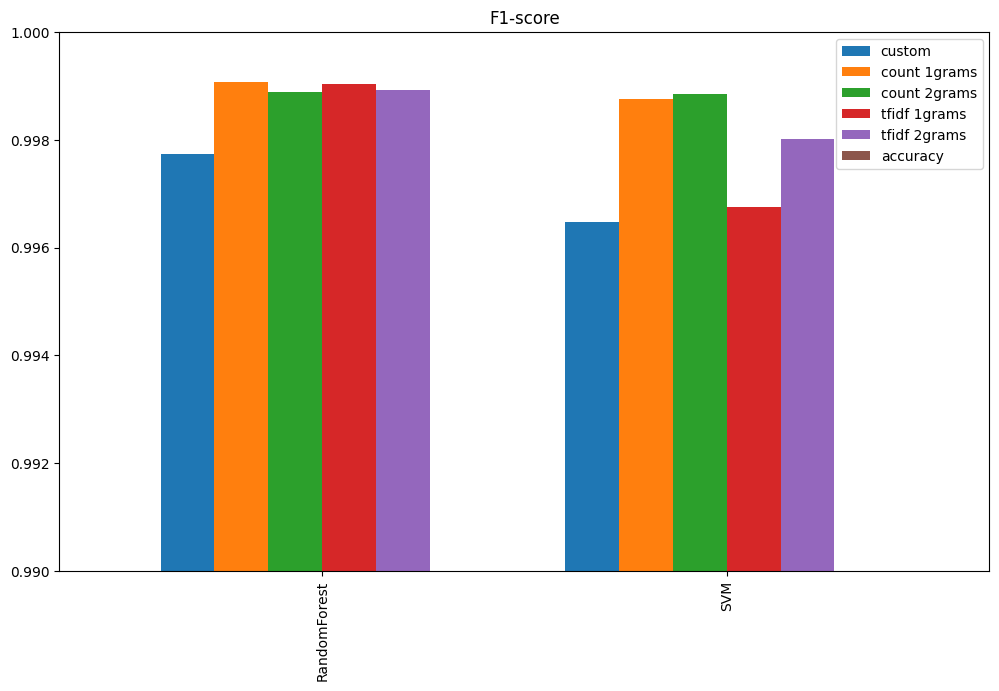

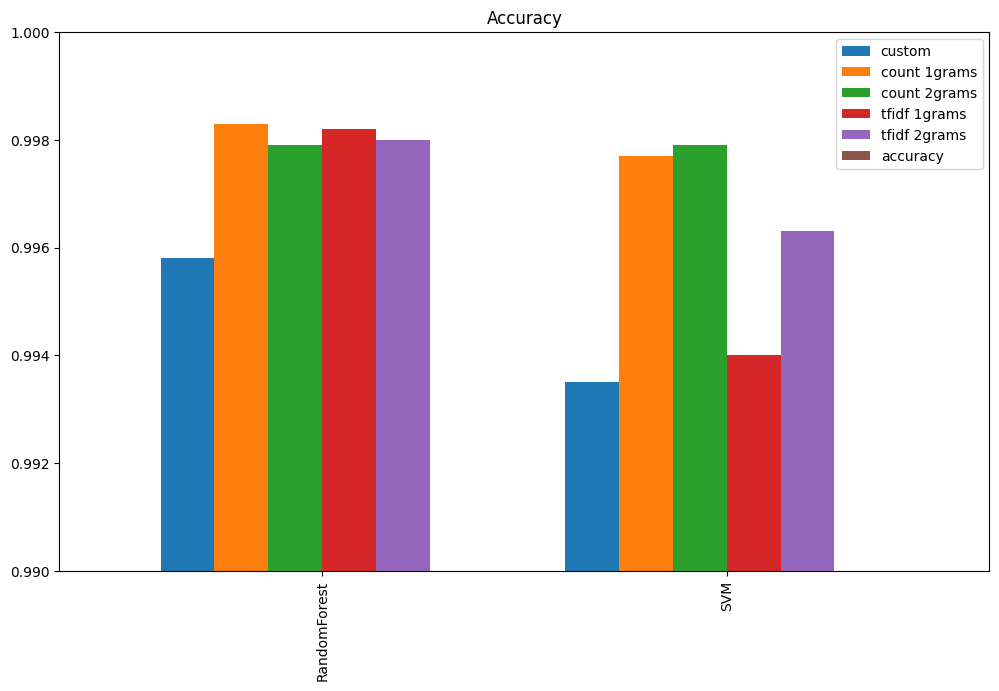

In [53]:
#Hàm lấy ra tên mô hình phân loại
def get_classifier_name(index):
    return index.split()[len(index.split())-1]
    
#Gộp theo tên mô hình phân loại
grouped = classifier_results.groupby(get_classifier_name)

#Tạo 2 DataFrame là f1-score và acuurancy
f1 = pd.DataFrame(columns=['custom', 'count 1grams', 'count 2grams', 'tfidf 1grams', 'tfidf 2grams', 'accuracy'])
acc = pd.DataFrame(columns=['custom', 'count 1grams', 'count 2grams', 'tfidf 1grams', 'tfidf 2grams', 'accuracy'])

for classifier, indices in grouped.groups.items():   

    #Khởi tạo giá trị
    f1.loc[classifier] = {
            'custom': 0,
            'count 1grams': 0,
            'count 2grams': 0,
            'tfidf 1grams': 0,
            'tfidf 2grams': 0,
    }
    
    acc.loc[classifier] = {
            'custom': 0,
            'count 1grams': 0,
            'count 2grams': 0,
            'tfidf 1grams': 0,
            'tfidf 2grams': 0,
    }

    #Gán giá trị F1-score và Accuracy từ classifier_results
    for fs in feature_spaces:
        f1[fs].loc[classifier] = classifier_results['F1-score'].loc[fs + ' ' + classifier]
        acc[fs].loc[classifier] = classifier_results['accuracy'].loc[fs + ' ' + classifier]

#Tạo biểu đồ F1-score
f, ax = plt.subplots()
ax.set_ylim([0.99,1])
f1.plot(kind='bar', figsize=(12,7), title='F1-score', ax=ax, width=0.8)

#Tạo biểu đồ Accuracy
f, ax = plt.subplots()
ax.set_ylim([0.99,1])
acc.plot(kind='bar', figsize=(12,7), title='Accuracy', ax=ax, width=0.8)


### Learning curves

In [55]:
def plot_learning_curve(df_row,X,Y):
    '''
    input - df_row: thứ tự dòng trong classifier_results
            X: dữ liệu
            Y: nhãn
    '''

    #Lựa chọn mô hình
    estimator = df_row['model']   
    title = 'Learning curves for classifier ' + df_row.name

    
    train_sizes = np.linspace(0.1,1.0,5)
    cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Số lượng mẫu")
    plt.ylabel("Score")
    
    #Tạo learning_curve
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, Y, cv=cv, n_jobs=-1, train_sizes=train_sizes, verbose=0)
    
    #Tính giá trị trung bình và độ lệch chuẩn khi huấn luyện và kiểm tra.
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    #Vẽ vùng thể hiện độ lệch chuẩn của score
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")

    plt.legend(loc="best")
    plt.show()

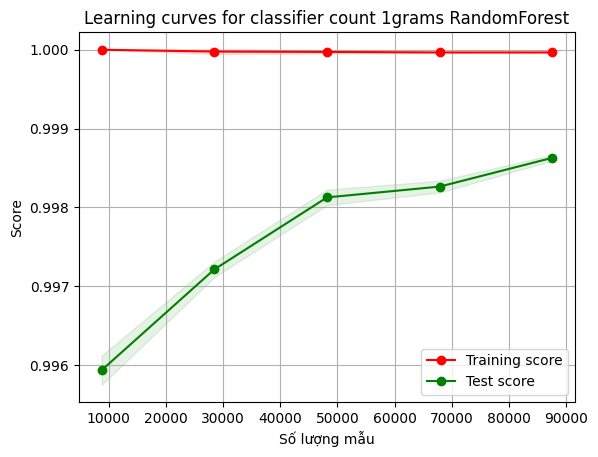

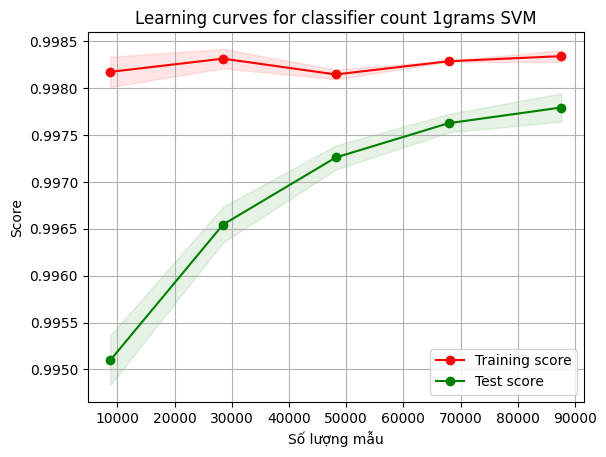

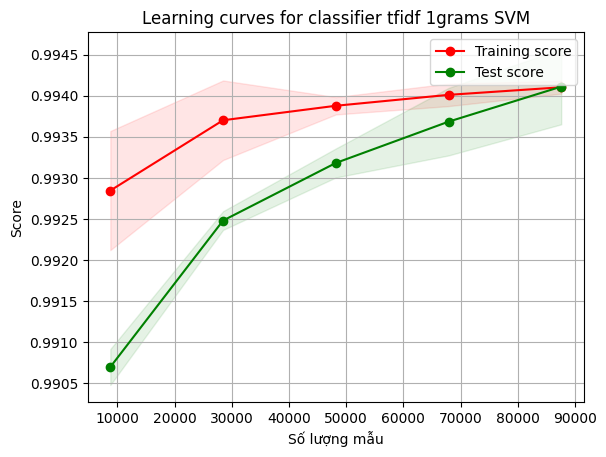

In [56]:
X = payloads['payload']
Y = payloads['is_malicious']

#Vẽ learning curve cho count 1grams RandomForest
plot_learning_curve(classifier_results.iloc[0],X,Y)

#Vẽ learning curve cho count 1grams SVM
plot_learning_curve(classifier_results.iloc[5],X,Y)

#Vẽ learning curve cho tfidf 1grams SVM
plot_learning_curve(classifier_results.iloc[8],X,Y)